# 3.2 Overlap in Lexical and Literary Vocabulary: Digging Deeper

In order to research the relationship between lexical and literary material in more detail we will look at individual literary texts. Which texts have more and which have less overlap with the lexical vocabulary?

As it turns out, this question is more complicated as it may seem. Longer texts will have more vocabulary items (and Multiple Word Expressions) in common with the lexical corpus than shorter texts, but that does not tell us anything. A simple count, therefore, is no longer sufficient. We will look at various ways to find a measure that will rank literary texts in a meaning fukl way.

### 3.2.0 Preparation

First import the necessary libraries. If you are running this notebook in Jupyter Lab you will need to install the Jupyter Lab ipywidgets extension (see [Introduction](../1_Preliminaries/1_Introduction.md), section 1.2.2.1). 

> The [LexicalRichness](https://pypi.org/project/lexicalrichness/) package by Lucas Shen has been slightly adapted for the present purposes. The package expects a data set in the English language in a raw text format that must be pre-processed (removal of interpunction, digits, etc.) and tokenized (cut up into individual words). These steps do not work well for the present data set. The adapted version, named `lexicalrichness_v` is imported from the `utils` directory. The usage information in the [LexicalRichness](https://pypi.org/project/lexicalrichness/) website is valid for `lexicalrichness_v` with the following exceptions:
> - the option use_TextBlob in LexicalRichness() is removed
> - the option use_tokenizer in LexicalRichness is added; default is use_tokenizer = False.

> If `use_tokenizer = False` (default) the main function expects a list as input; no tokenizing or preprocessing is performed. If `use_tokenizer = True` the function expects a string, which is preprocessed and tokenized (default behaviour in the original package).

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # this suppresses a warning about pandas from tqdm
import pandas as pd
from ipywidgets import interact
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import MWETokenizer
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import zipfile
import json
from tqdm.auto import tqdm
tqdm.pandas() # initiate pandas support in tqdm, allowing progress_apply() and progress_map()
import os
import sys
util_dir = os.path.abspath('../utils')
sys.path.append(util_dir)
from lexicalrichness_v import LexicalRichness as lr

Open the files `litlines.p` `lexlines.p`,, and `lex_vocab.txt` which were produced in [3_1_Lit_Lex_Vocab.ipynb](./3_1_Lit_Lex_Vocab.ipynb). The first two files contain the pickled versions of the DataFrames `lit_lines` and `lex_lines` in which the literary ([epsd2/literary](http://oracc.org/epsd2/literary)) and lexical corpora ([DCCLT](http://oracc.org/dcclt)) are represented in line-by-line format. The file `lex_vocab.txt` contains a list of the full lexical vocabulary, including Multiple Word Expressions.

In [2]:
lit_lines = pd.read_pickle('output/litlines.p')
lex_lines = pd.read_pickle('output/lexlines.p')
with open('output/lex_vocab.txt', 'r', encoding = 'utf8') as r:
    lex_vocab = r.read().splitlines()
lex_vocab.sort()

#### 3.2.0.1 Literary: By Composition
For the literary corpus we can take the line-by-line representation that was prepared in the previous notebook and transform that into a composition-by-composition representation. The DataFrame `lit_lines` includes the column `lemma_mwe` in which each line is represented as a sequence of lemmas and/or Multiple Word Expressions (lemmas connected by underscores). The `pandas` `groupby()` function is used to group on `id_text` and `text_name`. The aggregate function for the `lemma_mwe` column in this case is simply `' '.join`: all the entries (representing lines) are concatenated to form one long sequence of lemmas representing one composition.

In [3]:
lit_comp = lit_lines.groupby(
    [lit_lines["id_text"]]).aggregate(
    {"lemma_mwe": ' '.join}).reset_index()
lit_comp['id_text'] = [id[-7:] for id in lit_comp["id_text"]]
lit_comp[25:35]

,id_text,lemma_mwe
25,P254863,iri[city]n silim[healthy]v/i tag[touch]v/t lul...
26,P254864,kugzu[wise]aj namkugzu[wisdom]n na-an-ak-x[na]...
27,P254865,lu[person]n_niŋgina[truth]n zi[life]n utud[bea...
28,P254866,niŋ[thing]n_gu[neck]n_ŋar[place]v/t niŋ[thing]...
29,P254867,dubsar[scribe]n mu[name]n ni₂-x[na]na igi[eye]...
30,P254868,x-x[na]na mu[name]n diš[one]nu zu[know]v/t x-n...
31,P254869,dubsar[scribe]n emegir[sumerian]n nu-un-zu-x[n...
32,P254870,dubsar[scribe]n_tur[small]v/i bar[outside]n ni...
33,P254871,šah[pig]n šu[hand]n kar[flee]v/i iginzu[as-if]...
34,P254872,amaʾatud[slave]n sulum[contempt]n in-na-x[na]n...


The result is a DataFrame with two columns: `id_text`, and `lemma_mwe`. Each row represents a literary composition from the [epsd2/literary](http://oracc.org/epsd2/literary) corpus. Each cell in the column `lemma_mwe` contains a sequence of lemmas of one composition (with MWEs connected by underscores).

#### 3.2.0.2 Some Statistics for the Literary Corpus

In the following we will compute the number of vocabulary matches between each text in the literary corpus and the full lexical corpus. In order to interpret the number of matches propoerly, we will first compute a number of basic text measures, such as text length, type-token ratio, etc. In all the measures discussed below only the words that are properly lemmatized are counted.

| Measurement       |                                             |
|-------------------|---------------------------------------------|
| Text Length       | Number of lemmatized words and MWEs         |
| Lexical Variation | Number of unique lemmas and MWEs            |
| Type Token Ration | Lexical Variation divided by Text Length    |
| MTLD              | (see below)                                 |

Lexical richness measures the variation in vocabulary usage. Texts that use a relatively low number of unique lexemes (repeat the same words all over the place) receive a low lexical richness score. Texts that use the lexicon more ingenuously, using synonyms or circumscriptions to refer to the same concept, receive a higher lexical richness score. Lexical richness is used, among other things, to identify texts written by langauge learners, or to assess the difficulty of a text. For Sumerian literature, we may expect that compositions with high levels of repetition, such as certain hymns and narratives, end up with a low lexical richness score, whereas disputation texts may have a higher score.

The most straightforward lexical richness score is the Type Token Ratio (or TTR), which simply divides the number of unique lexemes by the total number of lexemes. This is a fine measurement to compare texts of (approximately) equal length, but does not work well for a corpus with texts of very different length, as is the case here. Short texts have higher TTR values than long texts, because longer texts will by necessity use the same words over and over again and function words such as "the" or "in" will be repeated many times whatever the lexical ingenuity of the author. A better measurement is called MTLD or Measure of Textual Lexical Diversity (McCarthy and Jarvis 2010). The MTLD value is calculated as the mean number of words in a text that will bring TTR from 1 (at the first word in the text) down to a threshold value (default is 0.720). In practice that means that a text is cut in many small units, each with approximately the same TTR - eliminating the effect of text length. This is a promising approach that may well work for Sumerian and a Python module that includes MTLD is available (lexicalrichness). Its usage here, however, is experimental and preliminary. The threshold value is based on the observation that when going through a text sequentially the TTR in any text will drop drastically as soon as the first repeated word is encountered. At some place in the text the TTR will stabilize and drop only very gradually later on. That place is approximated by the default threshold value of 0.720. It seems likely, however, that a valid threshold value is language dependent and that a language with very few function words, such as the literary register of Sumerian, might need a lower value. On the other hand, a corpus of texts with very substantial repetition (occasionaly repetition of entire lengthy passages) may well require a higher threshold. 

In [4]:
def lit_stats(lemmas):
    lemmas = lemmas.split()
    lemmas = [lemma for lemma in lemmas if not '[na]na' in lemma]
    lex = lr(lemmas)
    words = lex.words
    terms = lex.terms
    if words > 0:
        ttr = lex.ttr
        mtld = lex.mtld()
    else:
        ttr = 0
        mtld = 0
    return ' '.join(lemmas), words, terms, ttr, mtld

In [5]:
lit_comp['lemma_mwe'], lit_comp['length'], lit_comp['lex_var'], lit_comp['ttr'], lit_comp['mtld'] = \
    zip(*lit_comp['lemma_mwe'].progress_map(lit_stats))

We can get a first glimpse of the results by inspecting the basic descriptive statistics. For this, we ignore texts shorter than 200 lemmas, because measures like TTR and MTLD become rather meaningless for such short compositions. It appears that MTLD varies from 10.03 all the way up to 271.08, with a mean value of 79.53. That means that there is a text that, on average, needs only 10 words (two or three lines) to push the TTR under 0.720 - meaning a lot of repeated words (or repeated phrases) all over the place.

In [6]:
lit_comp.loc[lit_comp.length > 200].describe()

,length,lex_var,ttr,mtld
count,203.000000,203.000000,203.000000,203.000000
mean,577.605911,230.093596,0.475719,79.529468
std,527.749108,136.288701,0.128182,52.289918
min,201.000000,59.000000,0.164575,10.032316
25%,257.000000,138.000000,0.380827,38.803385
50%,352.000000,180.000000,0.481879,66.734320
75%,712.500000,280.500000,0.581742,106.224661
max,3139.000000,824.000000,0.753138,271.082712


### 3.2.1 Document Term Matrix

The literary corpus is transformed into a Document Term Matrix (or DTM), a table in which each column represents a lemma (or Multiple Word Expression)  and each row represents a Sumerian composition. Each cell is a number, 0 or 1, indicating whether or not that word appears  in a particular composition. This is a binary DTM, non-binary DTMs give the number of times a word appears in a composition.

The function `CountVectorizer()` (from the `Sklearn` package) is a very flexible tool with many possible parameters. The most common use case is a corpus of raw documents (probably in English), each of them consisting of a text string that needs to be pre-processed and tokenized (turned into a list of words or lemmas) before anything else can be done. Default pre-processing includes, for instance, lowercasing the entire text (so that thursday, Thursday, and THURSDAY will all be recognized as the same lemma). Default tokenizers assume that the text is in a modern (western) language and take spaces and punctuation marks as word dividers. The structure of our data is much simpler than that. Pre-processing is unnecessary, and tokenization should split the string *only* at blank spaces.

This can be achieved by defining custom tokenizer/preprocessor functions, and tell `Countvectorizer()` to use these. The custom tokenizer consists of the standard Python function `split()`; the preprocessor function does nothing at all. 

The parameter `vocabulary` is set to the variable `lex_vocab`, which includes all lemmas and MWEs in the lexical corpus. Without this parameter, `Countvectorizer()` will simply take each unique lemma in the literary corpus and make that into a column of the DTM. The `vocabulary` option allows us to compare the lexical vocabulary (the column names) with the usage of that vocabulary in each literary text (the rows).

In [7]:
cv = CountVectorizer(tokenizer=lambda x: x.split(), preprocessor=lambda x: x, vocabulary=lex_vocab, binary=True)
#Alternative way to do the same thing:
#cv = CountVectorizer(token_pattern = r'[^ ]+', vocabulary=lex_vocab, binary=True)
dtm = cv.fit_transform(lit_comp['lemma_mwe'])
lit_df = pd.DataFrame(dtm.toarray(), columns= cv.get_feature_names(), index=lit_comp["id_text"])
lit_df

,a[arm]n,a[arm]n_ak[do]v/t,a[arm]n_apin[plow]n,a[arm]n_bad[open]v/t,a[arm]n_bad[wall]n,a[arm]n_badsi[parapet]n,a[arm]n_be[diminish]v/t,a[arm]n_da[line]n,a[arm]n_dabašin[object]n,a[arm]n_daluš[sling]n,...,šuʾabdu[1]wn,šuʾi[barber]n,šuʾi[barber]n_egir[back]n,šuʾi[barber]n_gin[firm]v/i,šuʾi[barber]n_gina[offering]n,šuʾi[barber]n_gu[neck]n,šuʾi[barber]n_lugal[king]n,šuʾi[barber]n_saŋ[head]n,šuʾu[stone]n,šuʾura[goose]n
id_text,,,,,,,,,,,,,,,,,,,,,
P209784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P252215,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q000823,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000825,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The resulting DataFrame lit_df has a row for each *literary* composition and it has a column for every lemma/expression in the *lexical* corpus. The number of columns, therefore, should correspond to the size of the lexical vocabulary in the Venn diagram produced in the previous notebook:

![venn diagram 3](viz/venn_3.png)

As we have seen in the previous notebook, many of these words/expressions do not appear in the [epsd2/literary](http://oracc.org/epsd2/literary) corpus, and thus all cells in those columns are 0. If we remove those columns, we get the vocabulary that is shared between the lexical corpus and the literary corpus (the intersection of the circles in the Venn diagram). The left side of the Venn diagram (the literary vocabulary that does not appear in lexical texts) is not represented in the DTM. This DTM, therefore, should only be used to research *intersection* between the two (literary and lexical) vocabularies.

> The number of non-zero columns does not *exactly* correspond to the size of the intersection in the Venn diagram. The reason is that a word like **ašrinna\[object\]n**, a word that in the literary corpus only appears in the MWE **kid\[mat\]n_ašrinna\[object\]n**, is counted as a match in the Venn diagram, but only appears in the column **kid\[mat\]n_ašrinna\[object\]n** in the DTM. See the previous notebook section 3.1.3.1.

In [8]:
lit_df = lit_df.loc[: , lit_df.sum(axis=0) != 0].copy()
vocab = lit_df.columns # `vocab` is a list with all the vocabulary items currently in `lit_df`
lit_df

,a[arm]n,a[arm]n_ak[do]v/t,a[arm]n_bad[open]v/t,a[arm]n_dar[split]v/t,a[arm]n_daŋal[wide]v/i,a[arm]n_durah[goat]n,a[arm]n_e[leave]v/i,a[arm]n_gab[left]n,a[arm]n_gal[big]v/i,a[arm]n_gud[ox]n,...,šutum[storehouse]n,šutur[garment]n,šuziʾana[1]dn,šuš[cover]v/t,šušana[one-third]nu,šuši[sixty]nu,šušin[1]sn,šušru[distressed]v/i,šuʾi[barber]n,šuʾura[goose]n
id_text,,,,,,,,,,,,,,,,,,,,,
P209784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P251728,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P252215,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q000823,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q000825,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Number of Lexical/Literary Matches per Literary Composition. 
Since the DTM was built with the option `binary = True` the sum of each row equals the number of unique words/expressions that the composition shares with the lexical corpus. The code in the cell below may be simplified as:
```python
lit_df["n_matches"] = lit_df.sum(axis=1)
```
which will yield exactly the same result. The extra elements in the code are added for two reasons. First, if we add additional columns to the DataFrame, for instance composition names, the code will fail unless we add the option `numeric_only = True`. Second, if the (simplified) code is run twice, even with the option `numeric_only=True` the column `n_matches` will become part of the summation and the result in the new `n_matches` column will be twice the correct outcome. By explicitly stating that only the columns named after the lemmas in `vocab` should be used such accidents are avoided.

In [14]:
lit_df["n_matches"] = lit_df[vocab].sum(axis=1, numeric_only=True)

## Adding Metadata and Lexical Richness Statistics
Above, we computed various statistics for each of the literary compositions. The catalog file for epsd2/literary contains further information (such as the composition name). We can merge all of this information into a single DataFrame. The merge method is "inner," which means that only those rows that exist in both DataFrames will end up in the new DataFrame. Reduce the DataFrame by only admitting texts that include more than 200 lemmatized words. This last step removes a large number of documents - documents that are not lemmatized, fragments of literary texts that only include a few words, and texts such as lentils (school text) that contain a single proverb or a single line from a royal hymn. For these short texts, the quantitative comparison in the intersection with lexical vocabulary makes little sense.

In [15]:
# First get the metadata. 
file = "jsonzip/epsd2-literary.zip"
z = zipfile.ZipFile(file) 
st = z.read("epsd2/literary/catalogue.json").decode("utf-8")
j = json.loads(st)
cat_df = pd.DataFrame(j["members"]).T
#The important information, giving the tile of the literary text is sometimes found in 
# `designation` and sometimes in `subgenre`. Merge those two fields.
cat_df.loc[cat_df.designation.str[:13] == "CDLI Literary", "designation"] = cat_df.subgenre
# Exemplars have a P number (`id_text`), composite texts have a Q number (`id_composite`).
# Merge those two in `id_text`.
cat_df["id_text"] = cat_df["id_text"].fillna(cat_df["id_composite"])
# # Keep only `id_text` and `designation`.
cat_df = cat_df[["id_text", "designation"]]

Merge the Lexical Richness statistics (`lit_comp`) with the number of lexical matches from the DTM (`lit_df`) by the shared field `id_text`. Merge the resulting DataFrame (`lit_df2`) with the metadata (`cat_df`) and restrict the data set to compositions with more than 200 lemmatized words or MWEs.

In [16]:
lit_df2 = pd.merge(lit_comp[["id_text", "length", "mtld", "ttr", "lex_var"]], lit_df["n_matches"], on="id_text", how="inner")
lit_df2 = pd.merge(cat_df, lit_df2, on = 'id_text', how = 'inner')
lit_df2 = lit_df2.loc[lit_df2.length > 200]
lit_df2

,id_text,designation,length,mtld,ttr,lex_var,n_matches
2,P251713,"CUSAS 38, 05",268,89.333333,0.555970,149,129
8,P252270,ETCSL 4.02.01 Baba A (witness),211,183.236842,0.691943,146,138
14,P252333,ETCSL nn szir3-nam-szub-ba {d}en-ki-ka3-kam (w...,396,13.979005,0.371212,147,126
61,P346086,ETCSL 1.01.01 Enki and Ninhursaga (witness),201,23.366089,0.582090,117,107
62,P346087,ETCSL 1.06.03 Ninurta and Turtle (witness),272,63.826897,0.544118,148,139
...,...,...,...,...,...,...,...
901,Q000818,Proverbs: collection 26,242,99.130068,0.644628,156,151
904,Q000821,Proverbs: from Nippur,413,178.529830,0.607748,251,226
906,Q000823,Proverbs: from Ur,1399,117.398601,0.380272,532,482
908,Q000825,Proverbs: of unknown provenance,539,87.972272,0.556586,300,280


Sort by the number of lexical matches.

In [17]:
lit_df2 = lit_df2.sort_values(by = "n_matches", na_position="first", ascending=False)
lit_df2.head()

,id_text,designation,length,mtld,ttr,lex_var,n_matches
547,Q000351,Ninurta's exploits: a šir-sud (?) to Ninurta,3139,149.173640,0.262504,824,713
572,Q000380,The lament for Sumer and Ur,2668,57.629651,0.273988,731,616
561,Q000367,Lugalbanda in the mountain cave,1941,79.044336,0.326636,634,578
849,Q000750,The temple hymns,2498,86.438542,0.279023,697,570
531,Q000334,Enki and the world order,1937,89.129452,0.319050,618,558


# Discussion
Lugal-e (or [Ninurta's Exploits](http://etcsl.orinst.ox.ac.uk/cgi-bin/etcsl.cgi?text=c.1.6.2&display=Crit&charenc=gcirc#) has the highest number of matches (more than 700) with the Old Babylonian lexical corpus in [DCCLT](http://oracc.org/dcclt). But this is also the longest composition in the corpus. We can normalize by dividing the total number of matches (`n_matches`) by the number of unique lemmas (`lex_var`) in the text (`norm`).

In [18]:
lit_df2["norm"] = lit_df2["n_matches"] / lit_df2["lex_var"]
lit_df2.sort_values(by = "norm", na_position="first", ascending=False)

,id_text,designation,length,mtld,ttr,lex_var,n_matches,norm
754,Q000626,A tigi to Inana (Inana E),294,24.177292,0.329932,97,95,0.979381
812,Q000695,A tigi to Nergal (Nergal C),213,60.664253,0.455399,97,95,0.979381
137,P346203,ETCSL 2.05.04.23 Ishme-Dagan W (witness),215,84.493742,0.581395,125,121,0.968000
901,Q000818,Proverbs: collection 26,242,99.130068,0.644628,156,151,0.967949
870,Q000785,The three ox-drivers from Adab,268,21.743129,0.339552,91,88,0.967033
...,...,...,...,...,...,...,...,...
760,Q000632,A balbale to Inana (Dumuzid-Inana A),212,10.758310,0.278302,59,48,0.813559
851,Q000752,A hymn to the E-kur,244,10.425455,0.250000,61,46,0.754098
720,Q000559,Letter from Puzur-Šulgi to Ibbi-Suen about Išb...,205,46.402360,0.531707,109,82,0.752294
566,Q000372,The rulers of Lagaš,405,25.857924,0.441975,179,129,0.720670


# Exploring the Results
The following code displays the result in an interactive table that may be sorted (ascending or descending) in different ways for further exploration. The column `id_text` provides links to the editions in [epsd2/literary](http://oracc.org/epsd2/literary).

In [19]:
anchor = '<a href="http://oracc.org/epsd2/literary/{}", target="_blank">{}</a>'
lit = lit_df2.copy()
lit['id_text'] = [anchor.format(val,val) for val in lit['id_text']]

In [22]:
@interact(sort_by = lit.columns, rows = (1, len(lit), 1))
def sort_df(sort_by = "norm", ascending = False, rows = 10):
    return lit.sort_values(by = sort_by, ascending = ascending).reset_index(drop=True)[:rows].style

interactive(children=(Dropdown(description='sort_by', index=7, options=('id_text', 'designation', 'length', 'm…

Provide descriptive statistics of the `norm` variable.

In [25]:
lit['norm'].describe()

count    203.000000
mean       0.906160
std        0.053349
min        0.359833
25%        0.895003
50%        0.913462
75%        0.930233
max        0.979381
Name: norm, dtype: float64

# Creating Some Viz
Provisional. Mainly as example. Save the figures by opening an Output View (right click on output) and then right click on that Output View, select Save As.

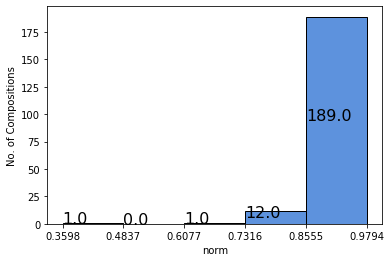

In [29]:
nbins = 5
column = 'norm'
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(lit[column], bins = nbins, edgecolor='k', color = "#5d92dd")
ax.set_xticks(bins)
for i in range(len(bins) - 1):
    plt.text(bins[i],counts[i]/2,str(counts[i]), fontsize = 16)
plt.ylabel('No. of Compositions')
plt.xlabel(column)
plt.savefig('viz/hist_norm.png', bbox_inches='tight')
plt.show()

Alternative. Much simpler - but does not return the bins and the counts.

In [ ]:
lit.mtld.hist(bins = 3);

In [ ]:
lit.plot.scatter(x = 'length', y = 'ttr', figsize = (10, 5));

# For Creating Output Only
The following code is used to create MarkDown tables from Pandas DataFrames. The tables can be included in the Compass Markdown files.

In [30]:
from tabulate import tabulate

ModuleNotFoundError: No module named 'tabulate'

In [ ]:
lit_tab = lit_df2.copy()
markdown = "[{}](http://oracc.org/epsd2/literary{}"
lit_tab['id_text'] = [markdown.format(val,val) for val in lit_df2['id_text']]
lit_tab = lit_tab.round({'ttr' : 3, 'norm': 3, 'mtld' : 3})

In [ ]:
rows = 10 # number of rows to be exported
col = 'norm' # column by which to sort
asc = True
tab = tabulate(etcsl_tab.sort_values(by=col, ascending=asc)[:rows],
         headers= etcsl_tab.columns , tablefmt="github", showindex=False)
with open('output/lit_tab.txt', 'w', encoding='utf8') as w:
    w.write(tab)

# Testing
Add one word at a time and see how that influences ttr. Does ttr arrive at a plateau?

In [ ]:
plt.figure(figsize=(20,10))
for id in lit_comp['id_text']:
    c = lit_comp.loc[lit_comp['id_text'] == id, 'lemma_mwe']
    c = c.iloc[0]

    ttr_l = []
    enum = range(1, len(c))
    for ind in enum:
        t = c[:ind]
        ttr = lr(t).ttr
        ttr_l.append(ttr)
    plt.plot(enum, ttr_l)
plt.show()

In [ ]:
lit_df2.loc[(86 < lit_df2.mtld) & (lit_df2.mtld < 162.6)].sort_values(by = 'mtld')

Following needs to be redone with Q numbers

In [ ]:
tetrad = {'c.2.5.8.1' : 1, 'c.2.5.3.2' : 1, 'c.2.5.5.2' : 1, 'c.4.16.1': 1}
decad = {'c.2.4.2.01' : 2, 'c.2.5.5.1' : 2, 'c.5.5.4' : 2, 'c.4.07.2' : 2, 'c.4.05.1' : 2,
         'c.4.80.2' : 2, 'c.1.1.4' : 2, 'c.1.3.2' : 2, 'c.4.28.1' : 2, 'c.1.8.1.5' : 2}
houseF = {'c.5.1.2' : 3,'c.5.1.3' : 3, 'c.1.8.1.4' : 3, 'c.1.6.2' : 3, 'c.2.1.5' : 3,
          'c.2.4.2.02' : 3, 'c.2.2.2' : 3, 'c.5.6.1' : 3, 'c.5.1.1' : 3, 'c.5.3.2' : 3,
          'c.1.4.3' : 3, 'c.5.6.3' : 3, 'c.5.4.1' : 3, 'c.5.3.1' : 3}
proverbs = {'c.6.1.01' : 4, 'c.6.1.02' : 4, 'c.6.1.03' : 4, 'c.6.1.04' : 4, 'c.6.1.05' : 4,
            'c.6.1.06' : 4, 'c.6.1.07' : 4,'c.6.1.08' : 4, 'c.6.1.09' : 4, 'c.6.1.10' : 4,
            'c.6.1.11' : 4, 'c.6.1.12' : 4, 'c.6.1.13' : 4, 'c.6.1.14' : 4,'c.6.1.15' : 4,
            'c.6.1.16' : 4, 'c.6.1.17' : 4, 'c.6.1.18' : 4, 'c.6.1.19' : 4, 'c.6.1.20' : 4,
            'c.6.1.21' : 4, 'c.6.1.22' : 4, 'c.6.1.23' : 4, 'c.6.1.24' : 4, 'c.6.1.25' : 4,
            'c.6.1.26' : 4, 'c.6.1.27' : 4, 'c.6.1.28' : 4, 'c.6.2.1' : 4, 'c.6.2.2' : 4,
            'c.6.2.3' : 4,'c.6.2.4' : 4,'c.6.2.5' : 4}

In [ ]:
educL = {}
educL.update(tetrad)
educL.update(decad)
educL.update(houseF)
educL.update(proverbs)
educ = lit_df2.loc[lit_df2.id_text.isin(educL)].sort_values(by = 'norm')
educ

In [ ]:
educ['category'] = [educL[id] for id in educ.id_text]

In [ ]:
educ.sort_values(by = 'mtld')

In [ ]:
etcsl.norm.describe()

In [ ]:
etcsl.loc[round(etcsl.norm, 3) == 0.874].style

In [ ]:
import seaborn as sns
#colors = {1 :'red', 2:'blue', 3:'green', 4:'black'}
#plt.scatter(educ.norm, educ.mtld, s =75, c=educ['category'].apply(lambda x: colors[x]), alpha = 1)
sns.scatterplot('norm', 'mtld', data=educ, hue='category', size = 'length', sizes = (50, 200), alpha = 0.75)

In [ ]:
educL['c.2.5.5.2']

In [ ]:
hymns = etcsl_df2.loc[etcsl_df2.id_text.str.startswith('c.2')]

In [ ]:
hymns.sort_values(by = 'id_text')

In [ ]:
genres = etcsl_df2.groupby(etcsl_df2.id_text.str[:5]).aggregate({'norm' : 'mean'})

In [ ]:
genres.plot()

In [ ]:
etcsl[['mtld', 'length', 'norm', 'lex_var', 'ttr', 'n_matches']].describe()

In [ ]:
DD = set(etcsl_comp.lemma_mwe.iloc[13])

In [ ]:
len(DD - set(lex_vocab))

In [ ]:
len(DD)

In [ ]:
etcsl_comp.iloc[13]

In [ ]:
etcsl_df2.loc[etcsl_df2.id_text == 'c.1.4.3']

In [ ]:
etcsl.norm.median()

> # Some thoughts

> * Step 1. Measure length of lemma_mwe in etcsl_comp and remove rows with len < 200.
> * Step 2. Create DTM (see below) of etcsl_comp, binary = True and vocabulary = lemma_mwe from lex (use lex_lines)
> * Step 3. Order compositions by highest match
> * Step 4. Normalize for text length (from Step 1)
> * Step 5. Same process for individual lex texts (which has highest match for Ura 4?)
> * Step 6. TF-IDF

> In future iteration: do *not* select among lexical texts - let the script figure out which lex compositions are most relevant.

> Perhaps: make DTM first - show that DTM.shape gives same numbers for lex vocabulary as second Venn diagram above. Remove all columns where sum == 0. Show that DTM.shape now gives total of overlap as in Venn diagram above. Then remove rows <= minimum. Tricky!